In [2]:

import re, numpy as np, string, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from nltk.corpus import stopwords
from collections import Counter
from PIL import Image
from nltk.stem.wordnet import WordNetLemmatizer
from yellowbrick.text.freqdist import FreqDistVisualizer
from yellowbrick.style import set_palette

import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from corextopic import corextopic as ct
from corextopic import vis_topic as vt

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [170]:
df = pd.read_csv('LApos.csv')

In [20]:
df.head()

,Unnamed: 0,city,year,comments,compound,pos,neg,sentiment,spacy_doc
18,253688,LA,2019.0,Great place and great location. Charles is ver...,0.9134,0.565,0.0,pos,Great place and great location. Charles is ver...
20,253690,LA,2019.0,"Wonderful hospitality, strongly recommend!",0.8221,0.896,0.0,pos,"Wonderful hospitality, strongly recommend!"
24,253696,LA,2021.0,Very nice place to stay...Charles was great,0.8016,0.590,0.0,pos,Very nice place to stay...Charles was great
26,253698,LA,2021.0,Great place great area great host,0.9231,0.804,0.0,pos,Great place great area great host
38,253710,LA,2015.0,Better luck next time,0.7096,0.747,0.0,pos,Better luck next time


In [21]:
df.columns

Index(['Unnamed: 0', 'city', 'year', 'comments', 'compound', 'pos', 'neg',
       'sentiment', 'spacy_doc'],
      dtype='object')

## NLTK Stop words

In [26]:

stop_words = stopwords.words('english')

#stop_words.extend([])

In [27]:
type(stop_words)

list

## Vectorizing & Document Matrix

In [28]:
vectorizer = CountVectorizer(stop_words='english')

docs = vectorizer.fit_transform(df.comments)

features = vectorizer.get_feature_names()


In [29]:

tf = TfidfVectorizer(stop_words=stopwords, min_df = 2, max_df=0.7)

docs = tf.fit_transform(df['comments'])

features = tf.get_feature_names()



"\ntf = TfidfVectorizer(stop_words=stopwords, min_df = 2, max_df=0.7)\n\ndocs = tf.fit_transform(df['comments'])\n\nfeatures = tf.get_feature_names()\n\n"

## Read samples of reviews

In [30]:
for sample in df['spacy_doc'].sample(5).values:
    print(sample)
    print()

This is my favorite place of stay here on airbnb, Super hosts they truly are awsome! :)

Lovely indoor and outdoor space . Peaceful . Great hiking out the door . Good for a peaceful getaway .

Super cute place, has everything you need and the pool was great!

Amazing views of downtown and great value.

Amazing host great in communication.



In [31]:
for sample in df['comments'].sample(5).values:
    print(sample)
    print()

Great space, convenient location, good value!

Awesome host, great space, incredible accommodating.

Very clean, neat, everyone stays to themselves. My stay was great. I loved it.

Great place to stay, nice place, nice area

If you would like to feel comfortable, this is your best bet !



## Most Used Words

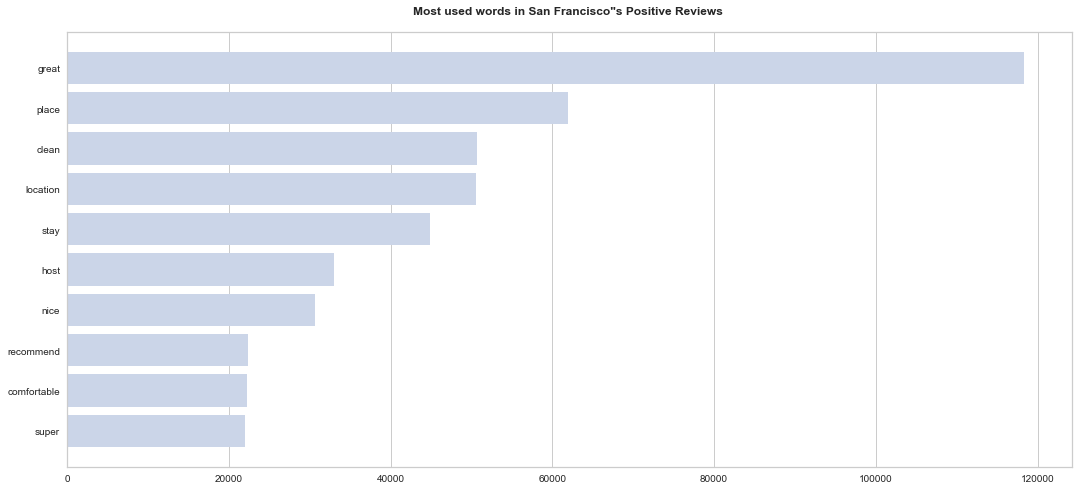

In [32]:
set_palette('pastel')
plt.figure(figsize=(18,8))
plt.title('Most used words in San Francisco"s Positive Reviews \n', fontweight='bold')

##yellowbrick
vis = FreqDistVisualizer(features=features, n = 10)
vis.fit(docs)
vis.poof;

## Creating World Cloud words

In [33]:
def wordcloud_words(wordcloud):
    plt.figure(figsize=(12, 10))
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis("off")
    plt.title(' San Francisco Positive Reviews\n', fontsize=18, fontweight='bold')
    plt.show()

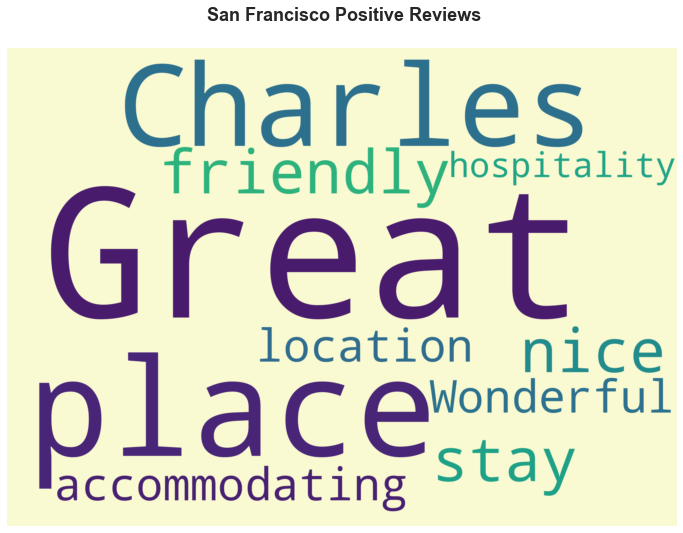

In [150]:
posWords = WordCloud(max_font_size=None, max_words = 10, background_color="lightgoldenrodyellow", 
                      width=3500, height=2500,
                      stopwords=stopwords.words('english')).generate(str(df.comments.values))

wordcloud_words(posWords)

## Simple Additional Cleaning

In [35]:
def clean(sents):
    for word in sents:
        word = re.sub('\s+', ' ', word)  
        word = re.sub("\'", "", word)  
        word = gensim.utils.simple_preprocess(str(word), deacc=True) 
        yield(word)  


# Apply cleaning

In [36]:
all_data = df.comments.values.tolist()
clean_sent = list(clean(all_data))
print(clean_sent[:1])

[['great', 'place', 'and', 'great', 'location', 'charles', 'is', 'very', 'friendly', 'and', 'very', 'accommodating']]


In [37]:
print(clean_sent[:5])

[['great', 'place', 'and', 'great', 'location', 'charles', 'is', 'very', 'friendly', 'and', 'very', 'accommodating'], ['wonderful', 'hospitality', 'strongly', 'recommend'], ['very', 'nice', 'place', 'to', 'stay', 'charles', 'was', 'great'], ['great', 'place', 'great', 'area', 'great', 'host'], ['better', 'luck', 'next', 'time']]


## Bigram & Trigram

In [38]:

bi_gram = gensim.models.Phrases(clean_sent, min_count=5, threshold=100) 

tri_gram = gensim.models.Phrases(bi_gram[clean_sent], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bi_gram)

trigram_mod = gensim.models.phrases.Phraser(tri_gram)

## Clean, Remove & Lemma

In [39]:

def cleaning(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
       
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    
    nlp = spacy.load("en_core_web_sm")
    
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])     
    
    clean_text = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]
    
    return clean_text


## Apply final cleaning on prev cleaned list

In [40]:
doc_clean = cleaning(clean_sent)
doc_clean[:5]

[['great', 'place', 'great', 'location', 'friendly', 'accommodate'],
 ['wonderful', 'hospitality', 'strongly', 'recommend'],
 ['place', 'stay', 'great'],
 ['great', 'place', 'great', 'area', 'great'],
 ['well', 'luck', 'next', 'time']]

## Create Dictionary & Corpus

In [41]:
doc_dict = corpora.Dictionary(doc_clean)

corpus = [doc_dict.doc2bow(text) for text in doc_clean]


## Build The LDA model

In [42]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=doc_dict,num_topics=8, random_state=33,
                                           update_every=1,chunksize=15,passes=10,alpha='symmetric',iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.203*"stay" + 0.163*"great" + 0.156*"recommend" + 0.120*"place" + '
  '0.071*"love" + 0.067*"highly" + 0.025*"safe" + 0.024*"house" + '
  '0.020*"parking" + 0.017*"convenient"'),
 (1,
  '0.155*"check" + 0.098*"apartment" + 0.094*"price" + 0.063*"fantastic" + '
  '0.055*"private" + 0.052*"feel" + 0.029*"service" + 0.029*"pleasant" + '
  '0.026*"night" + 0.025*"bathroom"'),
 (2,
  '0.341*"perfect" + 0.090*"close" + 0.042*"beach" + 0.026*"free" + '
  '0.025*"modern" + 0.023*"walk" + 0.020*"trip" + 0.019*"getaway" + '
  '0.017*"advertise" + 0.017*"away"'),
 (3,
  '0.112*"cute" + 0.104*"spot" + 0.076*"cozy" + 0.055*"peaceful" + '
  '0.046*"relax" + 0.046*"communicative" + 0.043*"little" + 0.033*"comfy" + '
  '0.029*"look" + 0.026*"friend"'),
 (4,
  '0.274*"great" + 0.158*"place" + 0.127*"location" + 0.093*"definitely" + '
  '0.089*"comfortable" + 0.043*"room" + 0.032*"awesome" + 0.021*"bed" + '
  '0.016*"br" + 0.012*"always"'),
 (5,
  '0.115*"stay" + 0.098*"beautiful" + 0.089*"comm

## List of words by topic

In [43]:
topics = lda_model.show_topics(formatted=False)

In [44]:
type(topics)

list

In [45]:
topics

[(0,
  [('stay', 0.20292853),
   ('great', 0.16301957),
   ('recommend', 0.15561755),
   ('place', 0.12011598),
   ('love', 0.070874095),
   ('highly', 0.06703886),
   ('safe', 0.025104666),
   ('house', 0.023744483),
   ('parking', 0.02043863),
   ('convenient', 0.017336182)]),
 (1,
  [('check', 0.1545504),
   ('apartment', 0.09762068),
   ('price', 0.09370324),
   ('fantastic', 0.0630623),
   ('private', 0.055130616),
   ('feel', 0.052430626),
   ('service', 0.02945052),
   ('pleasant', 0.029232921),
   ('night', 0.026003063),
   ('bathroom', 0.024877582)]),
 (2,
  [('perfect', 0.3405444),
   ('close', 0.0895801),
   ('beach', 0.04190611),
   ('free', 0.025945717),
   ('modern', 0.024510972),
   ('walk', 0.022853594),
   ('trip', 0.019531276),
   ('getaway', 0.01916211),
   ('advertise', 0.017081242),
   ('away', 0.016738188)]),
 (3,
  [('cute', 0.11240311),
   ('spot', 0.10395827),
   ('cozy', 0.07620799),
   ('peaceful', 0.055028964),
   ('relax', 0.046165776),
   ('communicative',

## Visualize the words By Topic

In [46]:
topics = lda_model.show_topics(formatted=False)

In [47]:
data_flat = [w for w_list in doc_clean for w in w_list]
counter = Counter(data_flat)

In [48]:
words_tops = []

for i, topic in topics:
    for word, weight in topic:
        words_tops.append([word, i , weight, counter[word]])
        

df_f = pd.DataFrame(words_tops, columns=['word', 'topic_n', 'most_appear', 'word_count']) 

In [49]:
df_f.sort_values('most_appear', ascending=False).head(12)

,word,topic_n,most_appear,word_count
70,amazing,7,0.484136,17800
20,perfect,2,0.340544,14853
40,great,4,0.274209,116281
0,stay,0,0.202929,49242
60,clean,6,0.200186,41963
1,great,0,0.163020,116281
41,place,4,0.158402,58715
2,recommend,0,0.155618,27075
10,check,1,0.154550,5676
61,great,6,0.153871,116281


## Word Count as Weights by Topic Visualization

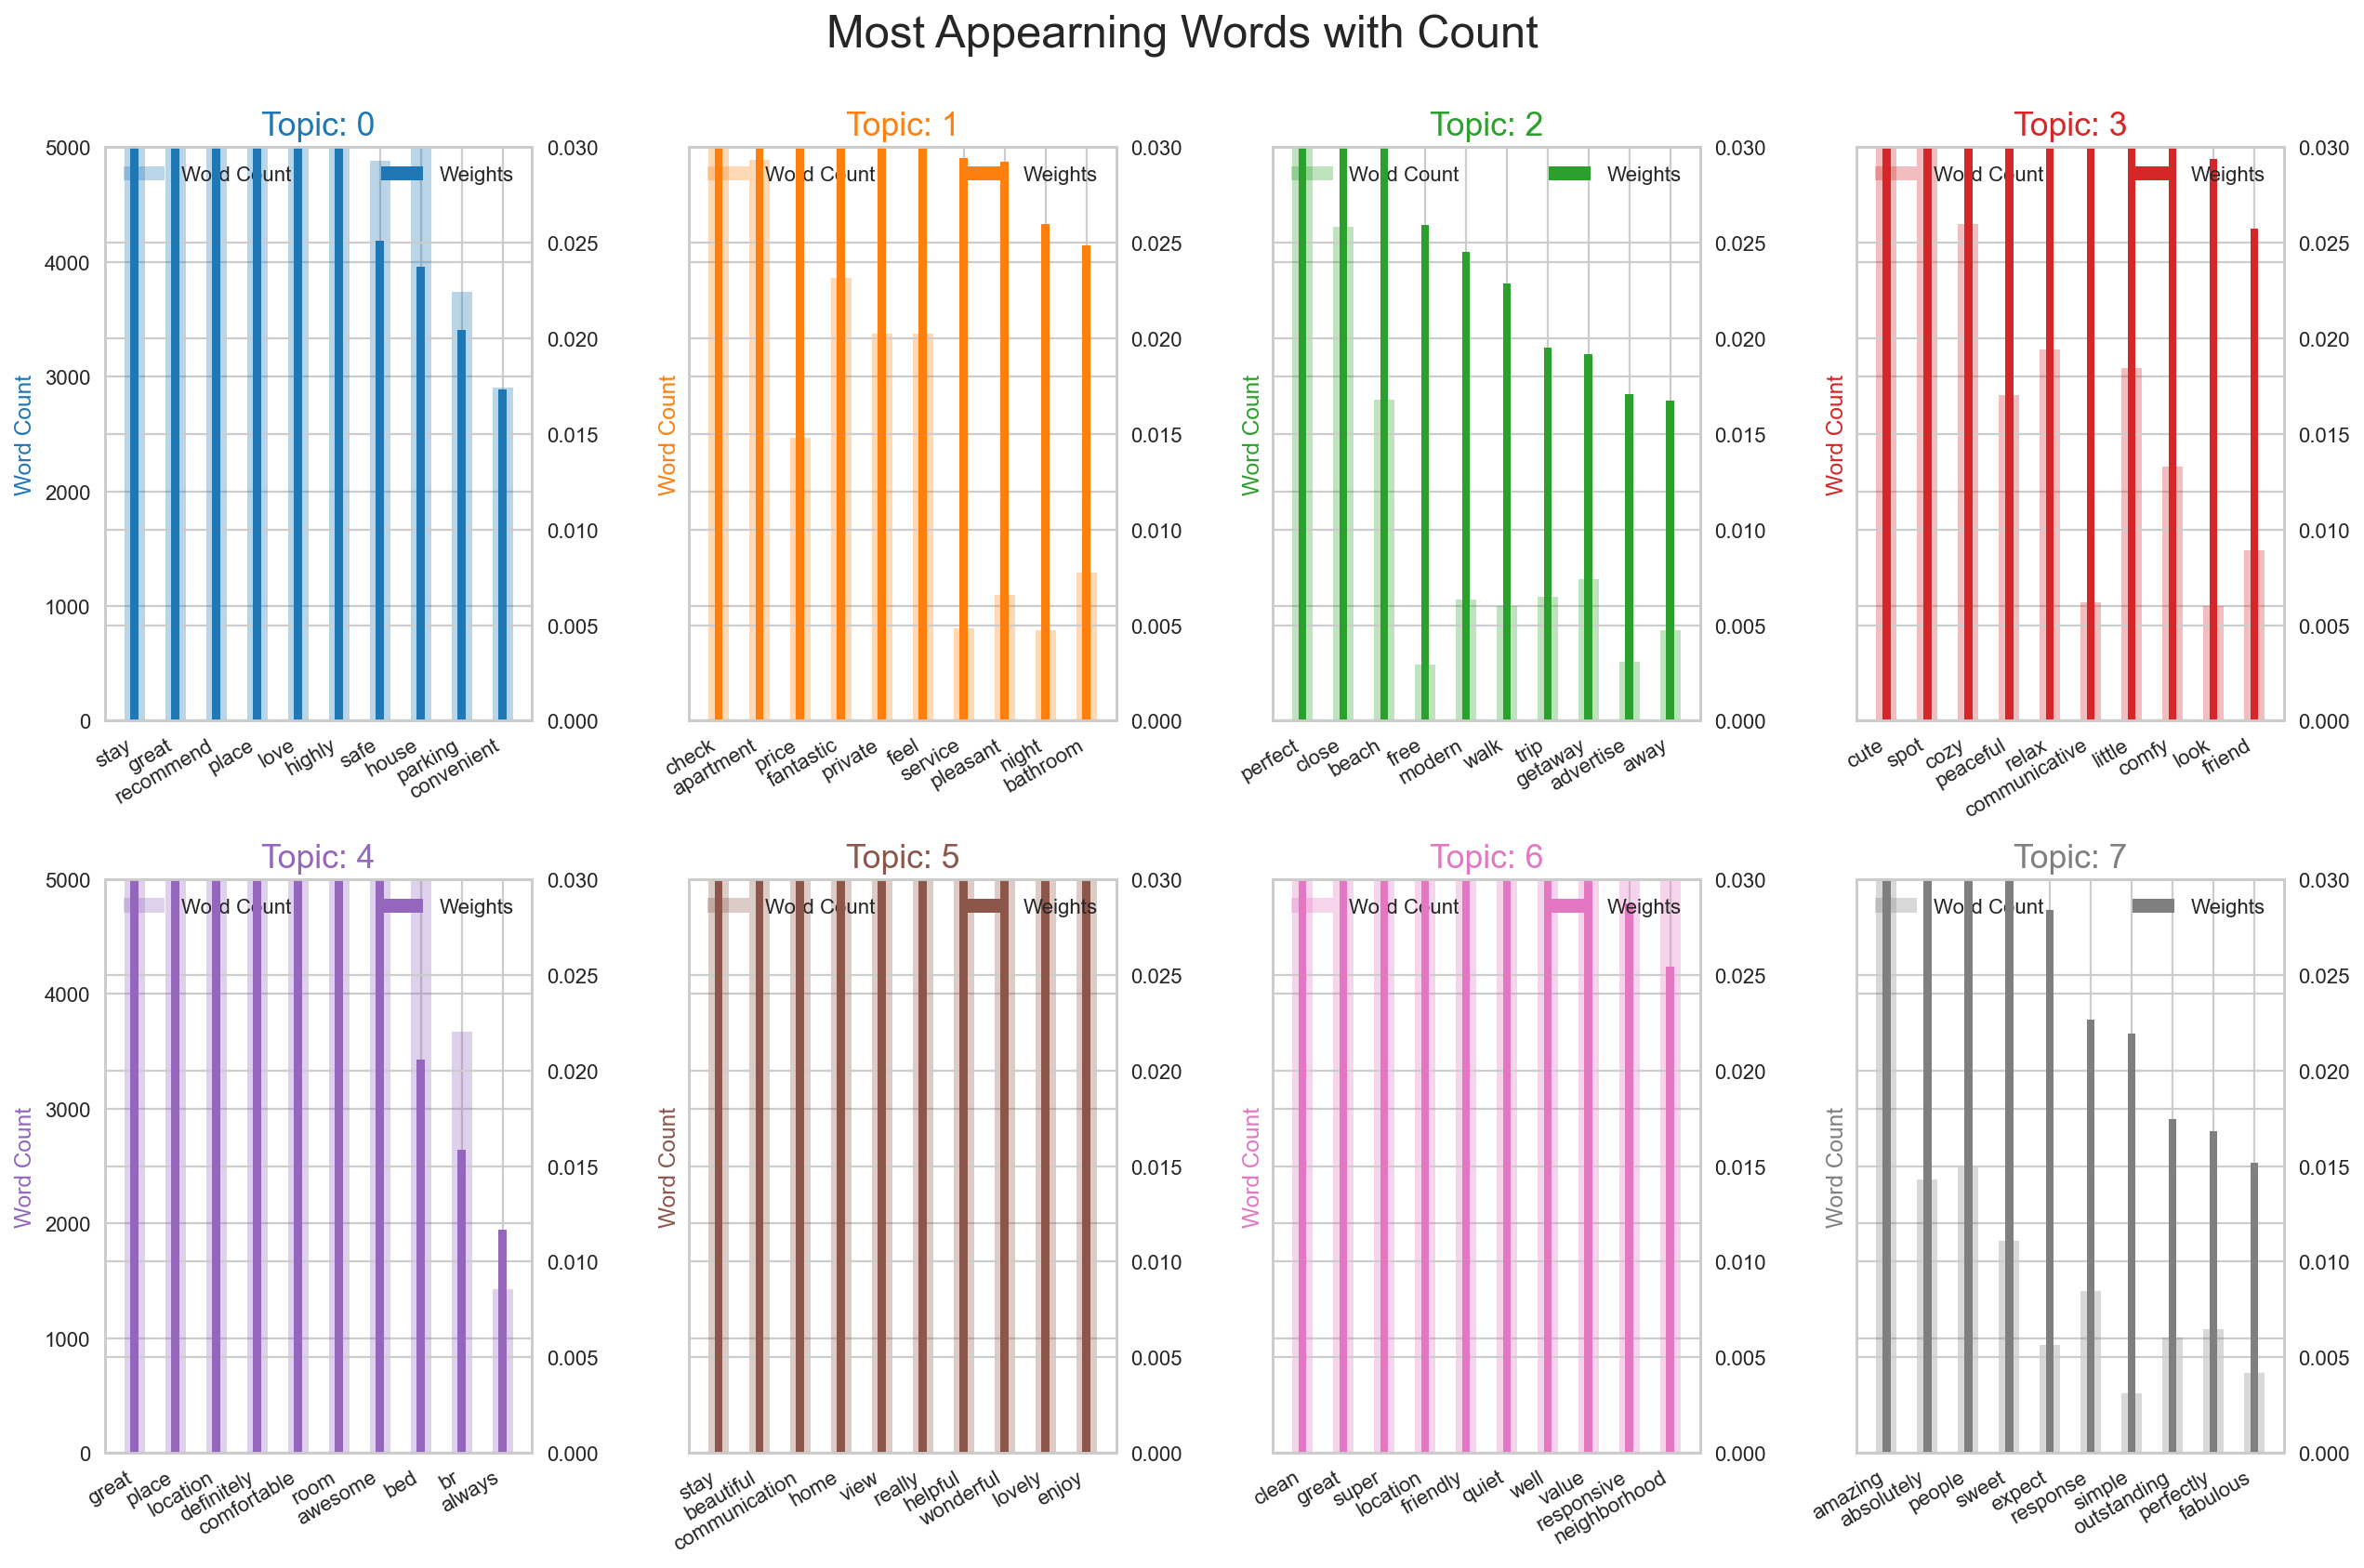

In [50]:
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    
    ax_twin.bar(x='word', height="most_appear", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    
    ax.set_xticklabels(df_f.loc[df_f.topic_n==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Most Appearning Words with Count', fontsize=22, y=1.05)   

plt.show()

## Words by Topic WordCloud

In [51]:

colors2 = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

topic_clouds = WordCloud(stopwords=stop_words,background_color='white', width=2500,height=1800, max_words=25, colormap='tab10',
                  color_func=lambda *args, **kwargs: colors2[i],prefer_horizontal=1.0)


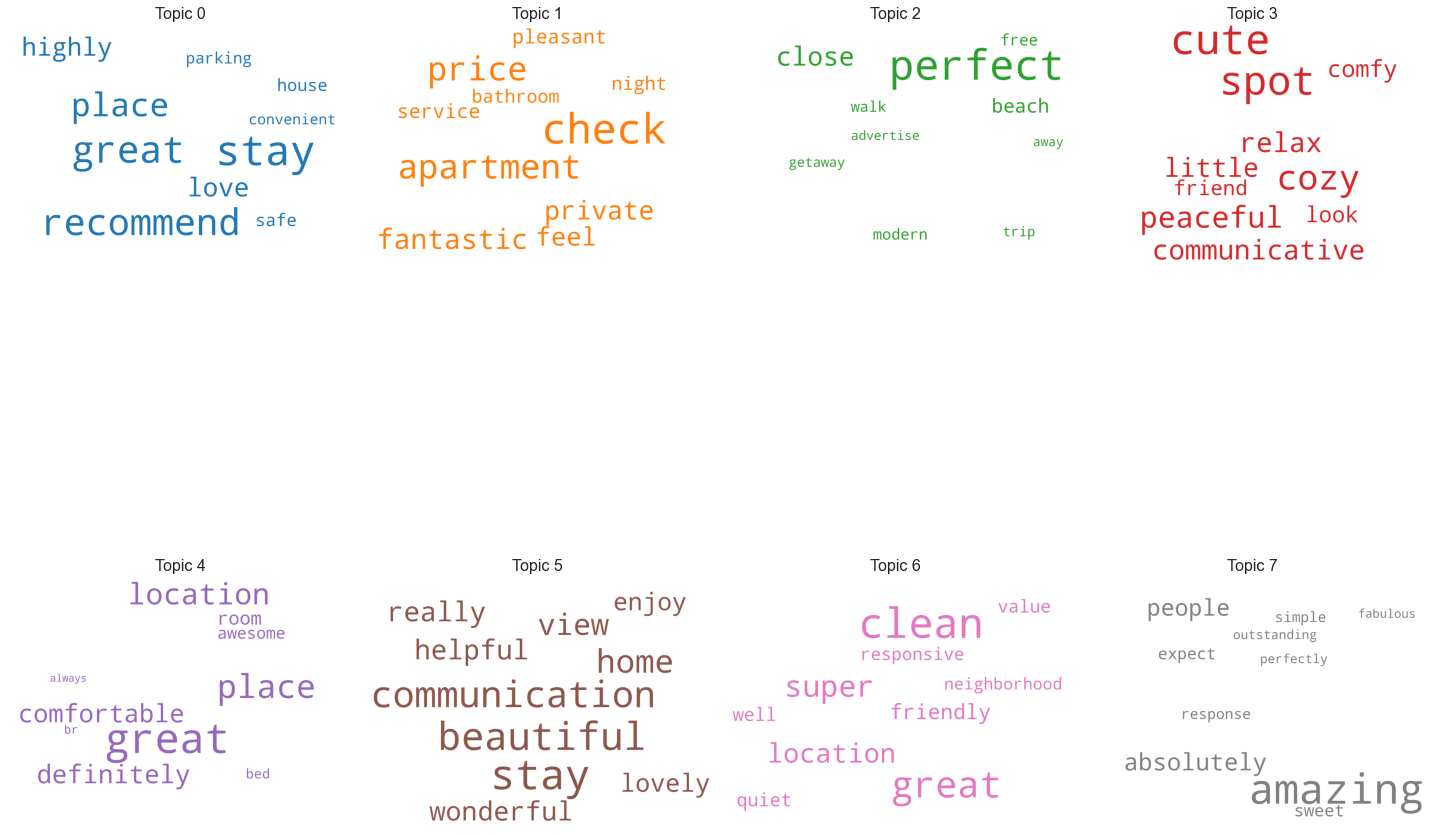

In [52]:
fig, axes = plt.subplots(2, 4, figsize=(20,20), sharex=True, sharey=True)
 

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    
    topic_words = dict(topics[i][1])
    topic_clouds.generate_from_frequencies(topic_words, max_font_size=300)
    
    plt.gca().imshow(topic_clouds)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##  NMF run using 3 topics

In [53]:

nmf = NMF(n_components=3)

nmf.fit(docs)

NMF(n_components=3)

In [54]:
topic_matrix = nmf.transform(docs)

In [55]:
topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')

topic_matrix_df['comments'] = df['comments']
topic_matrix_df.head()

,topic_0,topic_1,topic_2,comments
0,0.097819,0.046367,0.000000,Great place and great location. Charles is ver...
1,0.000264,0.012556,0.006567,"Wonderful hospitality, strongly recommend!"
2,0.041062,0.075196,0.007455,Very nice place to stay...Charles was great
3,0.134330,0.046438,0.000000,Great place great area great host
4,0.000709,0.000692,0.000995,Better luck next time


In [56]:
word_topic_matrix_df = pd.DataFrame(nmf.components_, columns=features).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2
00,0.000210,0.000000,0.000384
000,0.000000,0.000000,0.000057
0it,0.000000,0.000000,0.000060
0lce,0.000000,0.000000,0.000127
10,0.044519,0.163808,0.138878


## Read Samples from Topic 0 

In [57]:
for review in topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)['comments'].values:
    print(review)
    print()

Great, great, great, great, great. Great hosts, great location, great view, great communication, great hospitality. Superlative experience. Highly recommended.

Great host great communication great studio very comfortable and helpful host has great hospitality and great communication location is very safe and close to many great areas

Great experience, great place to stay, great host, great location, great communication, and great value.  A+++++

This was my second stay here. I came back because my first stay was so great (see earlier review) and this stay was equally great. Great location, great space, great host. Yes, it was great.

Great place to stay! Great location! Great hosts! Fab little place. Great shower and kitchen area! Great for a short or long stay. Thanks for being such great host and would recommend this place to anyone.

Great yard great bed great hammock great shower great living space great location.

Great working with George, great view, great pool, great house, g

## Read Samples from Topic 1 


In [58]:
for review in topic_matrix_df.sort_values(by='topic_1', ascending=False).head(5)['comments'].values:
    print(review)
    print()

Great place very pleasantly surprised how nice it was.  Great host and the place was fabulous very clean spacious set up perfect  I could not have asked fir a nicer place to stay !!  Family/kid friendly  great location.  Honestly this is the best place I have stayed at and would stay here again.

Awesome place to stay highly recommended. Definitely would stay here again. Henry was a great host and has a beautiful place!! Neighborhood was beautiful and peaceful nice place to take walks and feel comfortable if that’s something your interested in!!!!

Amazing stay! Definitely going back to her. Outstanding place and super nice to us!! Loved the place and her so much, worth every penny! Definitely recommend staying at her place. Even the outside view is amazing!

Amazing place. Great location and great little place. The outside deck and BBQ is amazing and great to have with the place. I would definitely recommend with 10 stars. Colin is also an amazing host and so easy to communicate with.

## Read Samples from Topic 2


In [59]:
for review in topic_matrix_df.sort_values(by='topic_2', ascending=False).head(5)['comments'].values:
    print(review)
    print()

This was by far the most stylish, clean and fun airbnb experience I've had yet.  Absolutely incredible hosts, a truly remarkable vintage property and clean, clean, clean!  Comfortable beds, a glistening pool, amazing original artwork and close to everything in sunny Long Beach.  Will definitely be coming back!  Thanks for the adventure!

Great Abnb experience. Beautiful place to be at, wonderful host to communicate with. Every time that I needed something or asked a question she would respond and would be there in person super rapidly, a pleasure meeting her, friendly, respectful and very supportive and caring. The home is located in a nice area, easy to access it, easy to park, with safe, nice and very easy entrance. Clean and nice kitchen & bathroom. Lovely room with comfortable bed. Happy to recommend it, and will gladly choose to be there again. Delightful host! Thank you!

A nice clean suite in a nice clean house, in a nice clean neighborhood.

Best airbnb experience ever. Tom was

# Top 10 Words from Each Topic

In [60]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [61]:
display_topics(nmf, features, 10)


Topic  0
great, location, host, communication, value, space, hosts, easy, stay, house

Topic  1
place, stay, definitely, amazing, recommend, beautiful, wonderful, highly, awesome, perfect

Topic  2
clean, nice, super, comfortable, location, host, easy, good, house, beautiful


In [62]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2
great,20.645958,0.337550,0.000000
location,6.182580,0.000000,3.167149
host,3.165625,0.513507,2.103657
communication,0.968677,0.000000,0.572408
value,0.833829,0.000000,0.164946
space,0.821519,0.000000,1.300096
hosts,0.644787,0.401738,0.631362
easy,0.615420,0.034911,1.938346
stay,0.581094,7.734546,0.885797
house,0.522655,0.000000,1.655341


In [63]:
word_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1,topic_2
place,0.000000,13.892001,0.000000
stay,0.581094,7.734546,0.885797
definitely,0.000000,2.854990,1.145741
amazing,0.000000,2.673987,0.681108
recommend,0.180869,2.661285,1.613919
beautiful,0.018104,1.432358,1.623548
wonderful,0.089136,1.106357,0.662674
highly,0.299195,1.103950,0.880075
awesome,0.128220,1.095281,0.322897
perfect,0.102167,1.034304,1.466824


In [64]:
word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)

,topic_0,topic_1,topic_2
clean,0.000000,0.000000,12.275021
nice,0.000000,0.772124,5.835043
super,0.000000,0.679705,4.575967
comfortable,0.000000,0.491714,4.240492
location,6.182580,0.000000,3.167149
host,3.165625,0.513507,2.103657
easy,0.615420,0.034911,1.938346
good,0.111181,0.394004,1.822686
house,0.522655,0.000000,1.655341
beautiful,0.018104,1.432358,1.623548


In [65]:
def top_reviews(topic_matrix_df, topic, num_of_reviews):
    return (topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(num_of_reviews)['comments']
            .values)

def top_words(word_topic_matrix_df, topic, n_of_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_of_words))[topic]

In [66]:
for review in top_reviews(topic_matrix_df, 'topic_0', 5):
    print(review)
    print()

Great, great, great, great, great. Great hosts, great location, great view, great communication, great hospitality. Superlative experience. Highly recommended.

Great host great communication great studio very comfortable and helpful host has great hospitality and great communication location is very safe and close to many great areas

Great experience, great place to stay, great host, great location, great communication, and great value.  A+++++

This was my second stay here. I came back because my first stay was so great (see earlier review) and this stay was equally great. Great location, great space, great host. Yes, it was great.

Great place to stay! Great location! Great hosts! Fab little place. Great shower and kitchen area! Great for a short or long stay. Thanks for being such great host and would recommend this place to anyone.



In [67]:
top_words(word_topic_matrix_df, 'topic_0', 10)

great            20.645958
location          6.182580
host              3.165625
communication     0.968677
value             0.833829
space             0.821519
hosts             0.644787
easy              0.615420
stay              0.581094
house             0.522655
Name: topic_0, dtype: float64

In [68]:
for review in top_reviews(topic_matrix_df, 'topic_1', 5):
    print(review)
    print()

Great place very pleasantly surprised how nice it was.  Great host and the place was fabulous very clean spacious set up perfect  I could not have asked fir a nicer place to stay !!  Family/kid friendly  great location.  Honestly this is the best place I have stayed at and would stay here again.

Awesome place to stay highly recommended. Definitely would stay here again. Henry was a great host and has a beautiful place!! Neighborhood was beautiful and peaceful nice place to take walks and feel comfortable if that’s something your interested in!!!!

Amazing stay! Definitely going back to her. Outstanding place and super nice to us!! Loved the place and her so much, worth every penny! Definitely recommend staying at her place. Even the outside view is amazing!

Amazing place. Great location and great little place. The outside deck and BBQ is amazing and great to have with the place. I would definitely recommend with 10 stars. Colin is also an amazing host and so easy to communicate with.

In [69]:
top_words(word_topic_matrix_df, 'topic_1', 10)

place         13.892001
stay           7.734546
definitely     2.854990
amazing        2.673987
recommend      2.661285
beautiful      1.432358
wonderful      1.106357
highly         1.103950
awesome        1.095281
perfect        1.034304
Name: topic_1, dtype: float64

In [70]:
for review in top_reviews(topic_matrix_df, 'topic_2', 5):
    print(review)
    print()

This was by far the most stylish, clean and fun airbnb experience I've had yet.  Absolutely incredible hosts, a truly remarkable vintage property and clean, clean, clean!  Comfortable beds, a glistening pool, amazing original artwork and close to everything in sunny Long Beach.  Will definitely be coming back!  Thanks for the adventure!

Great Abnb experience. Beautiful place to be at, wonderful host to communicate with. Every time that I needed something or asked a question she would respond and would be there in person super rapidly, a pleasure meeting her, friendly, respectful and very supportive and caring. The home is located in a nice area, easy to access it, easy to park, with safe, nice and very easy entrance. Clean and nice kitchen & bathroom. Lovely room with comfortable bed. Happy to recommend it, and will gladly choose to be there again. Delightful host! Thank you!

A nice clean suite in a nice clean house, in a nice clean neighborhood.

Best airbnb experience ever. Tom was

In [71]:
top_words(word_topic_matrix_df, 'topic_2', 10)

clean          12.275021
nice            5.835043
super           4.575967
comfortable     4.240492
location        3.167149
host            2.103657
easy            1.938346
good            1.822686
house           1.655341
beautiful       1.623548
Name: topic_2, dtype: float64

In [72]:
t1 = top_words(word_topic_matrix_df, 'topic_0', 100)
t1_10 = top_words(word_topic_matrix_df, 'topic_0', 10)

In [73]:
tl_dict = t1.to_dict()

In [157]:
tl_dict

{'great': 22.306573864382866,
 'host': 3.6467461298897907,
 'communication': 1.0134028893895723,
 'value': 0.8256376645627534,
 'space': 0.6406709222271788,
 'spot': 0.5290305214521863,
 'hosts': 0.4624569019243544,
 'experience': 0.4204076710868508,
 'house': 0.4024862556116113,
 'time': 0.38786779448009634,
 'easy': 0.3471347084158684,
 'neighborhood': 0.34454602820325086,
 'hospitality': 0.3354211361280713,
 'amenities': 0.32551029576775947,
 'thanks': 0.3136523967458667,
 'view': 0.31198207872781103,
 'area': 0.299802437051126,
 'price': 0.29267751573621903,
 'close': 0.24818900145178888,
 'views': 0.20089770773968196,
 'room': 0.19269361337261223,
 'responsive': 0.18453459479581086,
 'overall': 0.1763038215712514,
 'parking': 0.15652846441246007,
 'check': 0.15572721285518595,
 'quiet': 0.14928966392956158,
 'thank': 0.1490517810932578,
 'little': 0.14137067500199238,
 'home': 0.13508431638996446,
 'people': 0.13425626427451948,
 'recommended': 0.12939500481452143,
 'apartment': 0

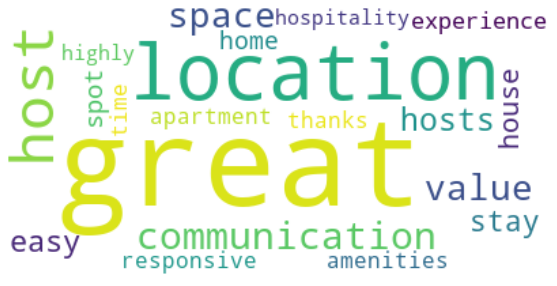

In [74]:
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(tl_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic1')
plt.show()


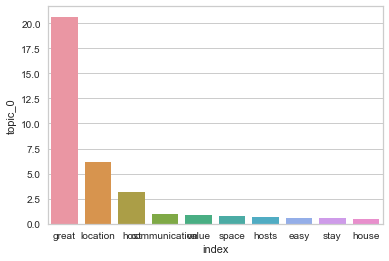

In [75]:
l_df = t1_10.to_frame()
l_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_0', data=l_df);

In [76]:
second_top = top_words(word_topic_matrix_df, 'topic_1', 100)
t2_10 = top_words(word_topic_matrix_df, 'topic_1', 10)

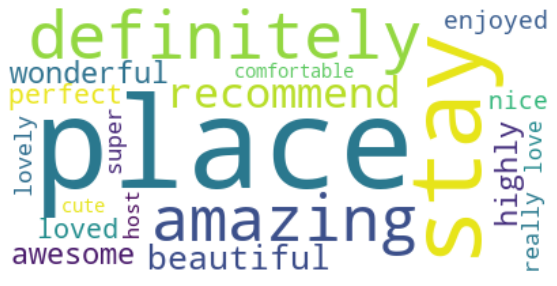

In [77]:
second_top_dict = second_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(second_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic2')
plt.show()


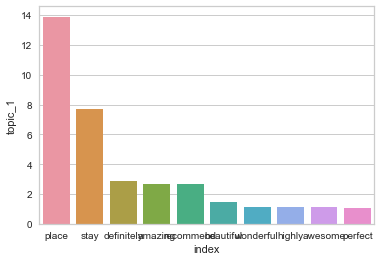

In [78]:
t2_df = t2_10.to_frame()
t2_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_1', data=t2_df);

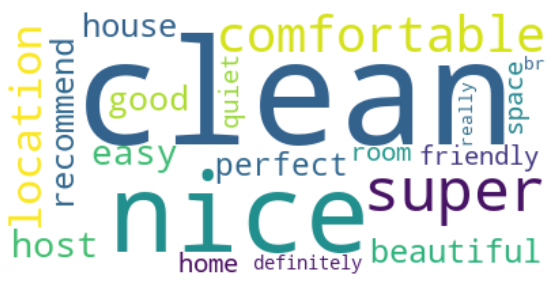

In [79]:
third_top = top_words(word_topic_matrix_df, 'topic_2', 100)
t3_10 = top_words(word_topic_matrix_df, 'topic_2', 10)


third_top_dict = third_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(third_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic3')
plt.show()

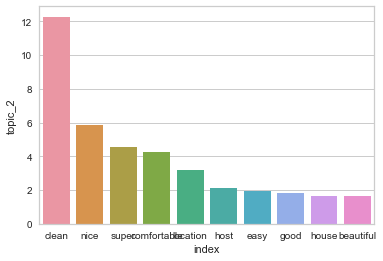

In [80]:
t3_df = t3_10.to_frame()
t3_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_2', data=t3_df);

## LDA model With 5 Topics

In [81]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,id2word=doc_dict,num_topics=5, random_state=33,
                                           update_every=1,chunksize=15,passes=10,alpha='symmetric',iterations=100,
                                           per_word_topics=True)

pprint(lda_model.print_topics())

[(0,
  '0.097*"beautiful" + 0.093*"stay" + 0.087*"communication" + 0.056*"view" + '
  '0.048*"really" + 0.047*"helpful" + 0.039*"lovely" + 0.038*"enjoy" + '
  '0.037*"excellent" + 0.028*"place"'),
 (1,
  '0.302*"recommend" + 0.130*"highly" + 0.081*"wonderful" + 0.060*"space" + '
  '0.055*"spot" + 0.040*"cozy" + 0.029*"peaceful" + 0.024*"communicative" + '
  '0.023*"little" + 0.016*"look"'),
 (2,
  '0.141*"great" + 0.120*"clean" + 0.103*"stay" + 0.069*"place" + '
  '0.058*"super" + 0.051*"definitely" + 0.049*"comfortable" + 0.043*"location" '
  '+ 0.026*"friendly" + 0.024*"room"'),
 (3,
  '0.337*"great" + 0.136*"location" + 0.087*"place" + 0.067*"perfect" + '
  '0.034*"check" + 0.034*"value" + 0.026*"area" + 0.021*"price" + '
  '0.018*"close" + 0.012*"private"'),
 (4,
  '0.145*"amazing" + 0.096*"home" + 0.067*"love" + 0.059*"awesome" + '
  '0.055*"place" + 0.047*"cute" + 0.037*"spacious" + 0.032*"parking" + '
  '0.029*"br" + 0.025*"kind"')]


## List of words by topic

In [82]:
topics = lda_model.show_topics(formatted=False)

In [83]:
type(topics)

list

In [84]:
topics

[(0,
  [('beautiful', 0.0965579),
   ('stay', 0.09305149),
   ('communication', 0.08713371),
   ('view', 0.05599715),
   ('really', 0.04774315),
   ('helpful', 0.047449216),
   ('lovely', 0.03909534),
   ('enjoy', 0.03755561),
   ('excellent', 0.036941458),
   ('place', 0.0275827)]),
 (1,
  [('recommend', 0.30248725),
   ('highly', 0.13030979),
   ('wonderful', 0.080796406),
   ('space', 0.05971949),
   ('spot', 0.05504635),
   ('cozy', 0.04035256),
   ('peaceful', 0.029138101),
   ('communicative', 0.024227712),
   ('little', 0.022615658),
   ('look', 0.015563894)]),
 (2,
  [('great', 0.14071955),
   ('clean', 0.120060116),
   ('stay', 0.10290533),
   ('place', 0.06861077),
   ('super', 0.058080673),
   ('definitely', 0.05120513),
   ('comfortable', 0.049268194),
   ('location', 0.04329917),
   ('friendly', 0.025610417),
   ('room', 0.023549834)]),
 (3,
  [('great', 0.3371289),
   ('location', 0.13632867),
   ('place', 0.087046),
   ('perfect', 0.06690146),
   ('check', 0.03445327),
 

## Visualize the words By Topic

In [85]:
topics = lda_model.show_topics(formatted=False)

In [86]:
data_flat = [w for w_list in doc_clean for w in w_list]
counter = Counter(data_flat)

In [87]:
words_tops = []

for i, topic in topics:
    for word, weight in topic:
        words_tops.append([word, i , weight, counter[word]])
        

df_f = pd.DataFrame(words_tops, columns=['word', 'topic_n', 'most_appear', 'word_count']) 

In [88]:
df_f.sort_values('most_appear', ascending=False).head(12)

,word,topic_n,most_appear,word_count
30,great,3,0.337129,116281
10,recommend,1,0.302487,27075
40,amazing,4,0.145110,17800
20,great,2,0.140720,116281
31,location,3,0.136329,50448
11,highly,1,0.130310,12241
21,clean,2,0.120060,41963
22,stay,2,0.102905,49242
0,beautiful,0,0.096558,18606
41,home,4,0.096171,10911


## Word Count as Weights by Topic Visualization

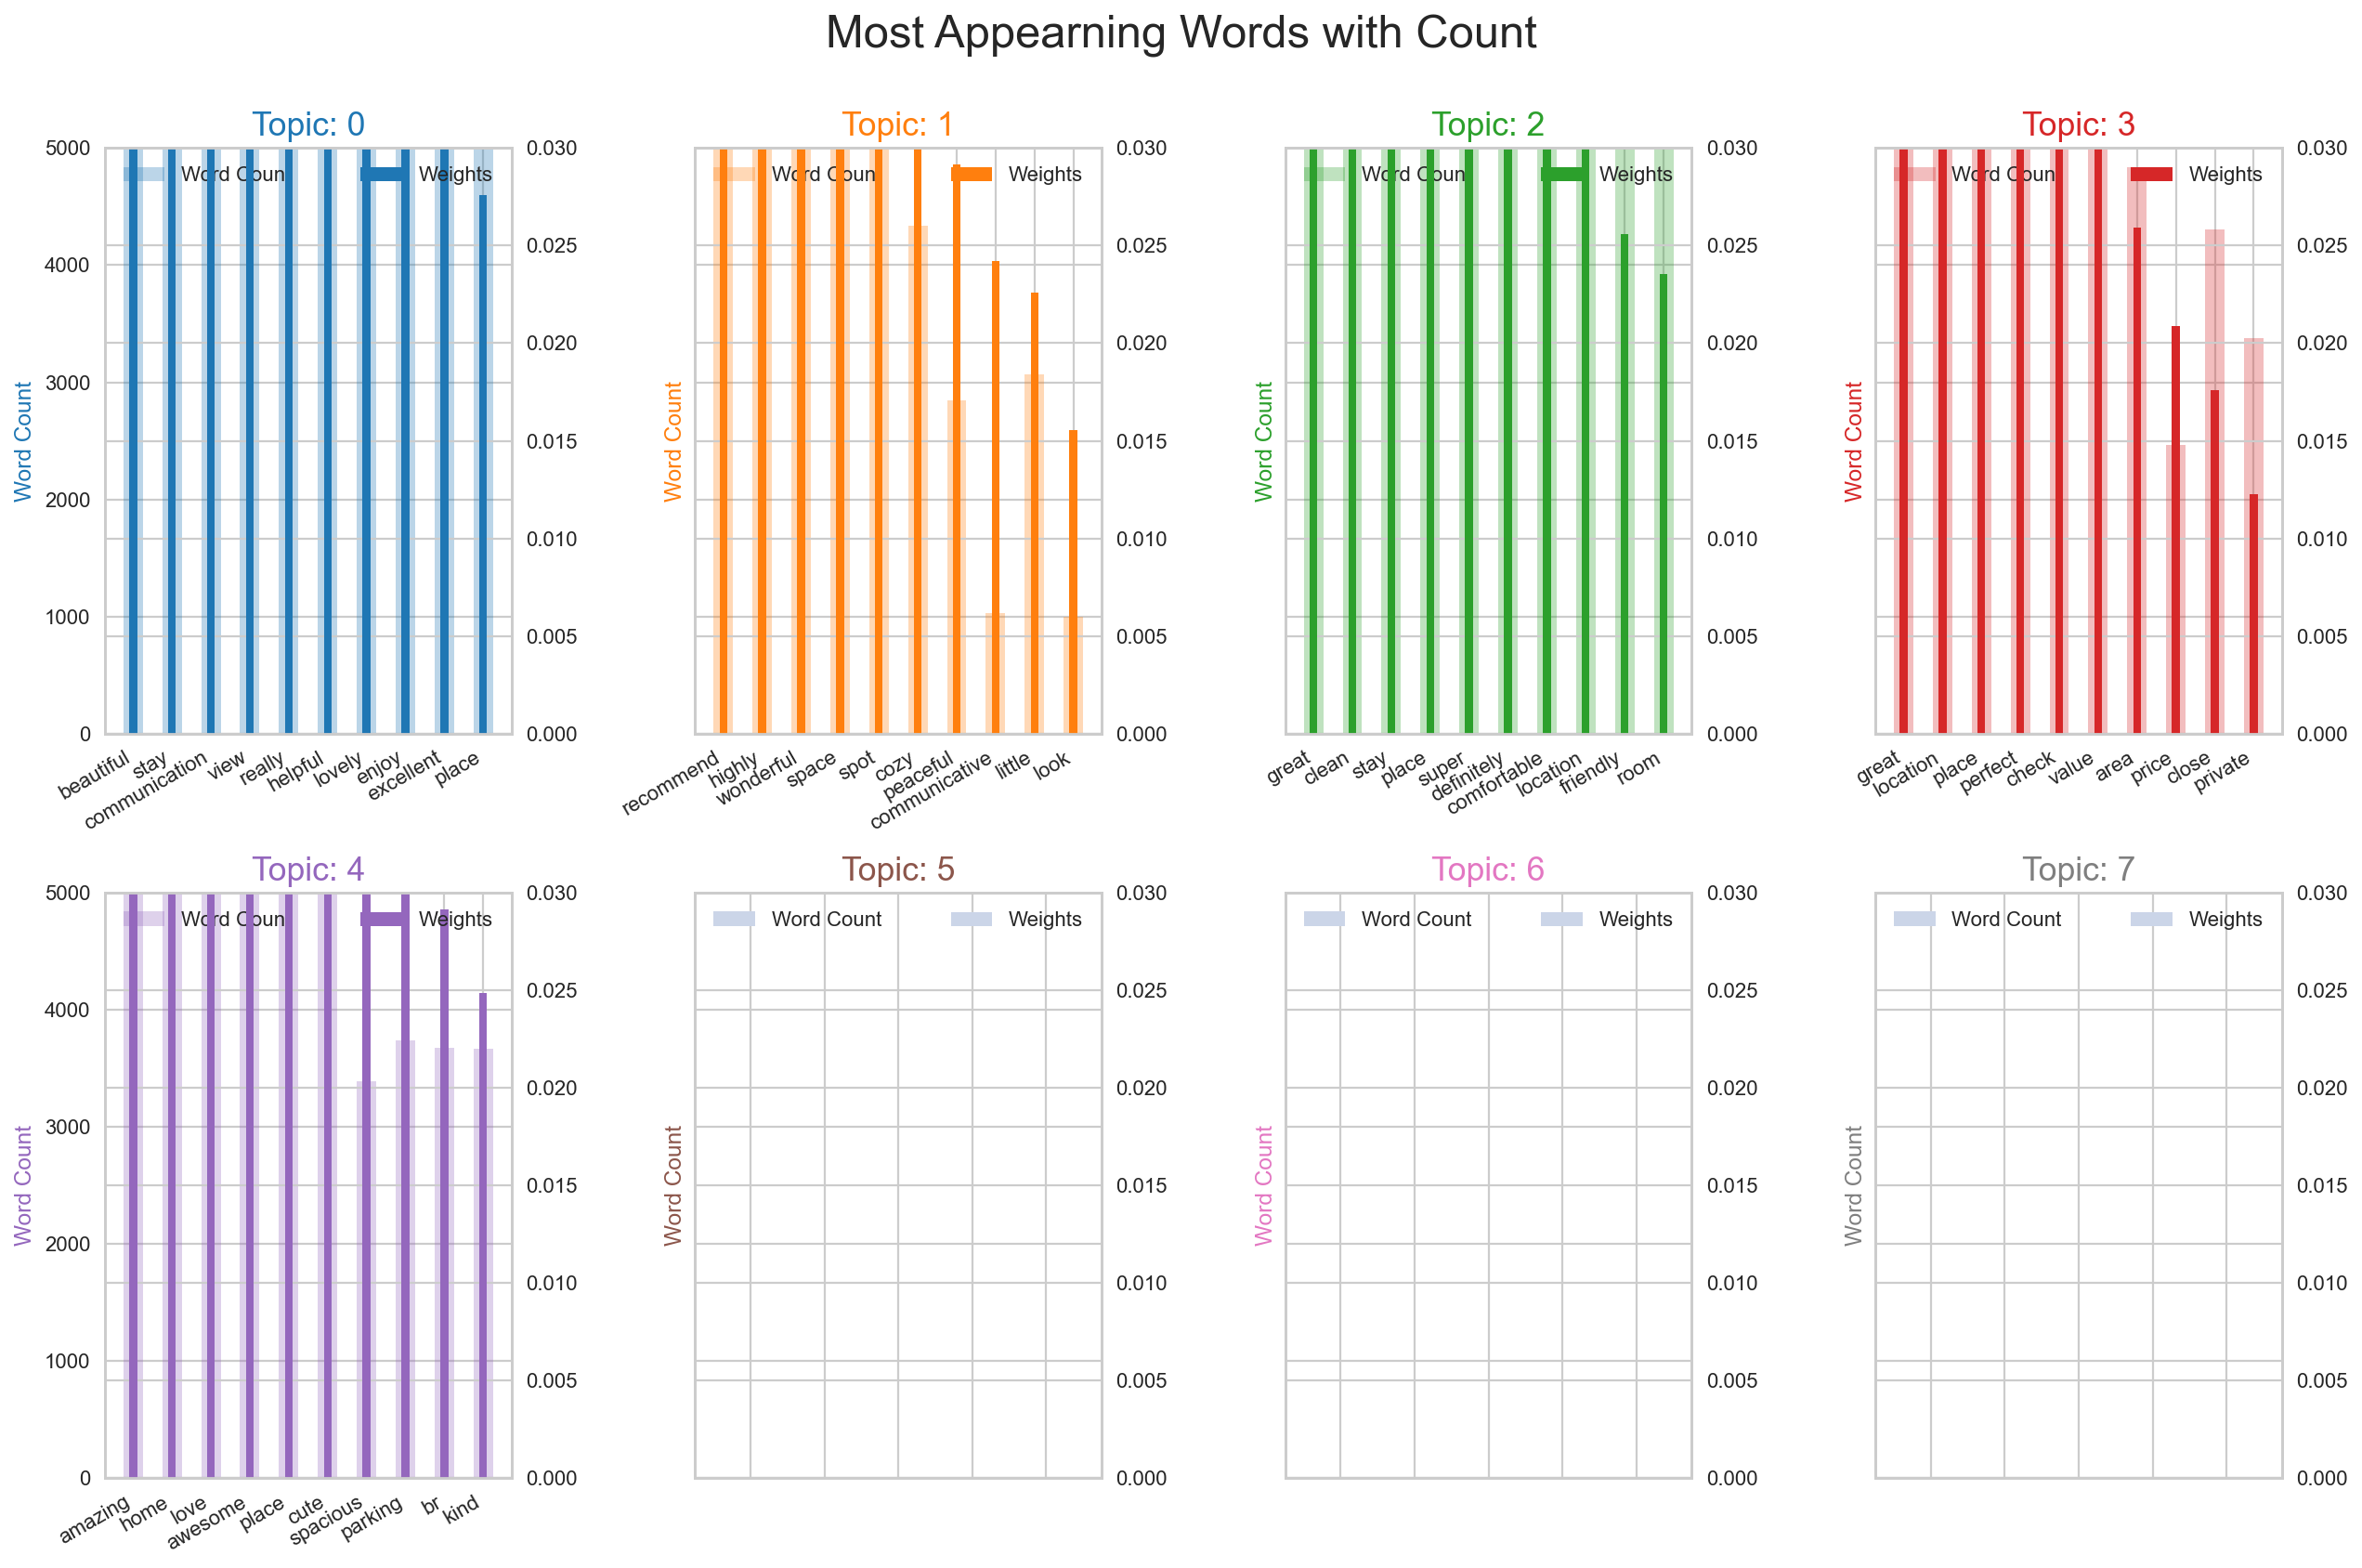

In [89]:
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  

for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    
    ax_twin.bar(x='word', height="most_appear", data = df_f.loc[df_f.topic_n==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 5000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    
    ax.set_xticklabels(df_f.loc[df_f.topic_n==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Most Appearning Words with Count', fontsize=22, y=1.05)   

plt.show()

## Words by Topic WordCloud

In [90]:

colors2 = [color for name, color in mcolors.TABLEAU_COLORS.items()] 

topic_clouds = WordCloud(stopwords=stop_words,background_color='white', width=2500,height=1800, max_words=25, colormap='tab10',
                  color_func=lambda *args, **kwargs: colors2[i],prefer_horizontal=1.0)


IndexError: list index out of range

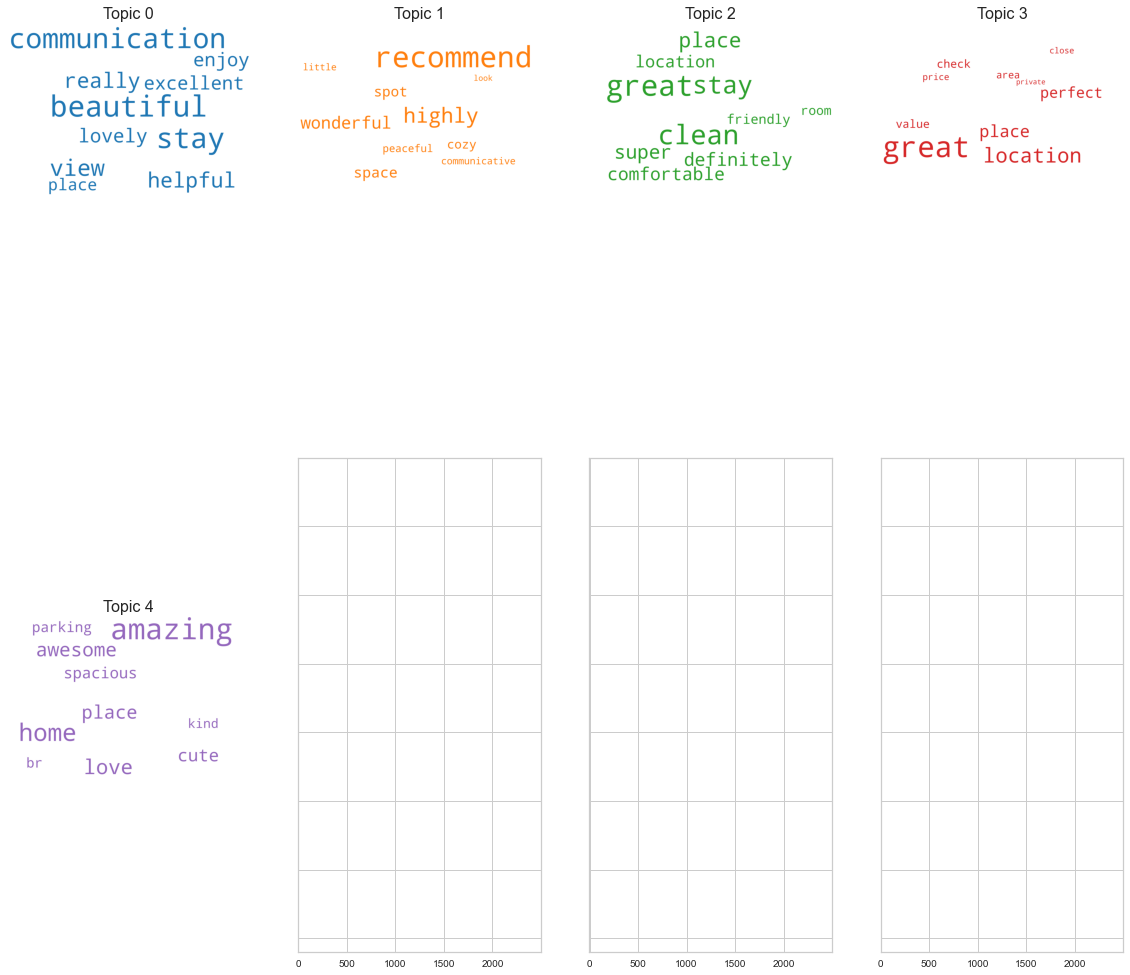

In [91]:
fig, axes = plt.subplots(2, 4, figsize=(20,20), sharex=True, sharey=True)
 

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    
    topic_words = dict(topics[i][1])
    topic_clouds.generate_from_frequencies(topic_words, max_font_size=300)
    
    plt.gca().imshow(topic_clouds)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')

plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##  NMF run using 5 topics

In [120]:

nmf5 = NMF(n_components=5)

nmf5.fit(docs)

NMF(n_components=5)

In [121]:
topic_matrix = nmf5.transform(docs)

In [122]:
topic_matrix_df = pd.DataFrame(topic_matrix).add_prefix('topic_')

topic_matrix_df['comments'] = df['comments']
topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4,comments
0,0.086499,0.056095,0.000000,0.000000,0.054425,Great place and great location. Charles is ver...
1,0.000440,0.009687,0.003616,0.008186,0.005734,"Wonderful hospitality, strongly recommend!"
2,0.042531,0.058873,0.012189,0.054351,0.000000,Very nice place to stay...Charles was great
3,0.137196,0.059187,0.000000,0.000000,0.000000,Great place great area great host
4,0.000753,0.000729,0.000953,0.000192,0.000274,Better luck next time


In [123]:
word_topic_matrix_df = pd.DataFrame(nmf5.components_, columns=features).T.add_prefix('topic_')
word_topic_matrix_df.head()

,topic_0,topic_1,topic_2,topic_3,topic_4
00,0.000276,0.000000,0.000385,0.000000,0.000000
000,0.000000,0.000000,0.000024,0.000038,0.000016
0it,0.000000,0.000000,0.000061,0.000000,0.000000
0lce,0.000000,0.000008,0.000119,0.000000,0.000000
10,0.024826,0.120309,0.105504,0.107893,0.075060


## Read Samples from Topic 0 

In [124]:
for review in topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)['comments'].values:
    print(review)
    print()

Great, great, great, great, great. Great hosts, great location, great view, great communication, great hospitality. Superlative experience. Highly recommended.

Great host great communication great studio very comfortable and helpful host has great hospitality and great communication location is very safe and close to many great areas

Great experience, great place to stay, great host, great location, great communication, and great value.  A+++++

The host was SUPER!!! Great stay! Great place! Great hospitality! Great area! Great atmosphere! Great parking! I really enjoyed my stay and will definitely visit again as well as refer anyone to rent this space of Ms. Georgetta "Airbnb"

Great place to stay! Great location! Great hosts! Fab little place. Great shower and kitchen area! Great for a short or long stay. Thanks for being such great host and would recommend this place to anyone.

This was my second stay here. I came back because my first stay was so great (see earlier review) and t

## Read Samples from Topic 1 


In [125]:
for review in topic_matrix_df.sort_values(by='topic_1', ascending=False).head(5)['comments'].values:
    print(review)
    print()

Perfect place, great Hostess! The house has everything you need. Excellent place for relaxation. DNA place is the best place I ever stayed so far. Thanks, I definitely recommend the Pool House

Great place very pleasantly surprised how nice it was.  Great host and the place was fabulous very clean spacious set up perfect  I could not have asked fir a nicer place to stay !!  Family/kid friendly  great location.  Honestly this is the best place I have stayed at and would stay here again.

Amazing stay! Definitely going back to her. Outstanding place and super nice to us!! Loved the place and her so much, worth every penny! Definitely recommend staying at her place. Even the outside view is amazing!

Love love love the place. It’s the coolest Airbnb I have stayed at in LA. Location is amazing, the open floor plan high ceiling is amazing. The fire place is amazing. The beds and sheets are amazing. I love this place. LOVE.

Amazing place. Great location and great little place. The outside d

## Read Samples from Topic 2


In [126]:
for review in topic_matrix_df.sort_values(by='topic_2', ascending=False).head(5)['comments'].values:
    print(review)
    print()

A nice clean suite in a nice clean house, in a nice clean neighborhood.

This was by far the most stylish, clean and fun airbnb experience I've had yet.  Absolutely incredible hosts, a truly remarkable vintage property and clean, clean, clean!  Comfortable beds, a glistening pool, amazing original artwork and close to everything in sunny Long Beach.  Will definitely be coming back!  Thanks for the adventure!

Great Abnb experience. Beautiful place to be at, wonderful host to communicate with. Every time that I needed something or asked a question she would respond and would be there in person super rapidly, a pleasure meeting her, friendly, respectful and very supportive and caring. The home is located in a nice area, easy to access it, easy to park, with safe, nice and very easy entrance. Clean and nice kitchen & bathroom. Lovely room with comfortable bed. Happy to recommend it, and will gladly choose to be there again. Delightful host! Thank you!

Great clean spot with easy access to

# Top 10 Words from Each Topic

In [127]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [128]:
display_topics(nmf, features, 10)


Topic  0
great, host, communication, value, space, spot, hosts, experience, house, time

Topic  1
place, recommend, amazing, highly, nice, awesome, definitely, beautiful, loved, perfect

Topic  2
clean, nice, super, comfortable, host, easy, house, quiet, room, friendly

Topic  3
stay, definitely, enjoyed, beautiful, amazing, wonderful, comfortable, recommend, loved, home

Topic  4
location, perfect, good, amazing, beautiful, recommend, excellent, wonderful, easy, highly


In [129]:
word_topic_matrix_df.sort_values(by='topic_0', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
great,22.306574,0.000000,0.000000,0.000000,0.000000
host,3.646746,0.393656,2.070829,0.000000,0.000000
communication,1.013403,0.000000,0.517989,0.080663,0.092328
value,0.825638,0.000000,0.126161,0.000000,0.187276
space,0.640671,0.000000,1.055655,0.054140,0.741237
spot,0.529031,0.000000,0.307682,0.033507,0.000000
hosts,0.462457,0.238092,0.410833,0.425635,0.603646
experience,0.420408,0.000000,0.282994,0.000000,0.000000
house,0.402486,0.000000,1.397043,0.240682,0.486084
time,0.387868,0.097204,0.218213,0.025396,0.002430


In [130]:
word_topic_matrix_df.sort_values(by='topic_1', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
place,0.000000,15.997293,0.000000,0.000000,0.000000
recommend,0.000000,2.329952,1.128940,1.112637,0.988120
amazing,0.000000,1.881929,0.000000,1.253730,1.622862
highly,0.076751,1.196658,0.615462,0.167280,0.760407
nice,0.000000,1.116749,5.977025,0.000000,0.000000
awesome,0.000000,0.984533,0.069092,0.350542,0.724273
definitely,0.000000,0.879301,0.585067,3.764120,0.386368
beautiful,0.000000,0.704688,0.789464,1.379863,1.339964
loved,0.000000,0.570719,0.336001,0.886231,0.426915
perfect,0.000000,0.553992,0.362267,0.551105,2.533752


In [131]:
word_topic_matrix_df.sort_values(by='topic_2', ascending=False).head(10)

,topic_0,topic_1,topic_2,topic_3,topic_4
clean,0.000000,0.000000,12.862303,0.000000,0.000000
nice,0.000000,1.116749,5.977025,0.000000,0.000000
super,0.000000,0.510222,4.681186,0.432913,0.000000
comfortable,0.000000,0.000000,4.092394,1.158905,0.103387
host,3.646746,0.393656,2.070829,0.000000,0.000000
easy,0.347135,0.000000,1.683205,0.294400,0.794941
house,0.402486,0.000000,1.397043,0.240682,0.486084
quiet,0.149290,0.098181,1.349065,0.160191,0.061642
room,0.192694,0.000000,1.258965,0.000000,0.025917
friendly,0.112568,0.185923,1.243227,0.353083,0.317976


In [132]:
def top_reviews(topic_matrix_df, topic, num_of_reviews):
    return (topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(num_of_reviews)['comments']
            .values)

def top_words(word_topic_matrix_df, topic, n_of_words):
    return (word_topic_matrix_df
            .sort_values(by=topic, ascending=False)
            .head(n_of_words))[topic]

In [133]:
for review in top_reviews(topic_matrix_df, 'topic_0', 5):
    print(review)
    print()

Great, great, great, great, great. Great hosts, great location, great view, great communication, great hospitality. Superlative experience. Highly recommended.

Great host great communication great studio very comfortable and helpful host has great hospitality and great communication location is very safe and close to many great areas

Great experience, great place to stay, great host, great location, great communication, and great value.  A+++++

The host was SUPER!!! Great stay! Great place! Great hospitality! Great area! Great atmosphere! Great parking! I really enjoyed my stay and will definitely visit again as well as refer anyone to rent this space of Ms. Georgetta "Airbnb"

Great place to stay! Great location! Great hosts! Fab little place. Great shower and kitchen area! Great for a short or long stay. Thanks for being such great host and would recommend this place to anyone.



In [134]:
top_words(word_topic_matrix_df, 'topic_0', 10)

great            22.306574
host              3.646746
communication     1.013403
value             0.825638
space             0.640671
spot              0.529031
hosts             0.462457
experience        0.420408
house             0.402486
time              0.387868
Name: topic_0, dtype: float64

In [135]:
for review in top_reviews(topic_matrix_df, 'topic_1', 5):
    print(review)
    print()

Perfect place, great Hostess! The house has everything you need. Excellent place for relaxation. DNA place is the best place I ever stayed so far. Thanks, I definitely recommend the Pool House

Great place very pleasantly surprised how nice it was.  Great host and the place was fabulous very clean spacious set up perfect  I could not have asked fir a nicer place to stay !!  Family/kid friendly  great location.  Honestly this is the best place I have stayed at and would stay here again.

Amazing stay! Definitely going back to her. Outstanding place and super nice to us!! Loved the place and her so much, worth every penny! Definitely recommend staying at her place. Even the outside view is amazing!

Love love love the place. It’s the coolest Airbnb I have stayed at in LA. Location is amazing, the open floor plan high ceiling is amazing. The fire place is amazing. The beds and sheets are amazing. I love this place. LOVE.

Amazing place. Great location and great little place. The outside d

In [136]:
top_words(word_topic_matrix_df, 'topic_1', 10)

place         15.997293
recommend      2.329952
amazing        1.881929
highly         1.196658
nice           1.116749
awesome        0.984533
definitely     0.879301
beautiful      0.704688
loved          0.570719
perfect        0.553992
Name: topic_1, dtype: float64

In [137]:
for review in top_reviews(topic_matrix_df, 'topic_2', 5):
    print(review)
    print()

A nice clean suite in a nice clean house, in a nice clean neighborhood.

This was by far the most stylish, clean and fun airbnb experience I've had yet.  Absolutely incredible hosts, a truly remarkable vintage property and clean, clean, clean!  Comfortable beds, a glistening pool, amazing original artwork and close to everything in sunny Long Beach.  Will definitely be coming back!  Thanks for the adventure!

Great Abnb experience. Beautiful place to be at, wonderful host to communicate with. Every time that I needed something or asked a question she would respond and would be there in person super rapidly, a pleasure meeting her, friendly, respectful and very supportive and caring. The home is located in a nice area, easy to access it, easy to park, with safe, nice and very easy entrance. Clean and nice kitchen & bathroom. Lovely room with comfortable bed. Happy to recommend it, and will gladly choose to be there again. Delightful host! Thank you!

Great clean spot with easy access to

In [138]:
top_words(word_topic_matrix_df, 'topic_2', 10)

clean          12.862303
nice            5.977025
super           4.681186
comfortable     4.092394
host            2.070829
easy            1.683205
house           1.397043
quiet           1.349065
room            1.258965
friendly        1.243227
Name: topic_2, dtype: float64

In [139]:
t1 = top_words(word_topic_matrix_df, 'topic_0', 100)
t1_10 = top_words(word_topic_matrix_df, 'topic_0', 10)

In [140]:
tl_dict = t1.to_dict()

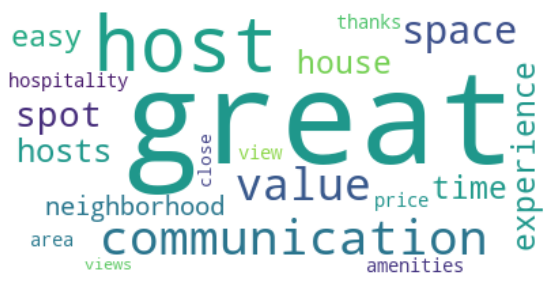

In [148]:
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(tl_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('laPosHosts')
plt.show()


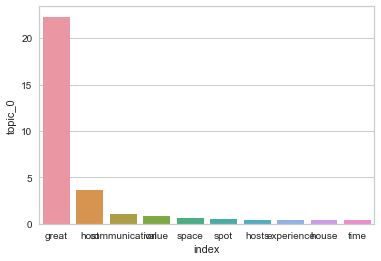

In [142]:
l_df = t1_10.to_frame()
l_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_0', data=l_df);

In [143]:
second_top = top_words(word_topic_matrix_df, 'topic_1', 100)
t2_10 = top_words(word_topic_matrix_df, 'topic_1', 10)

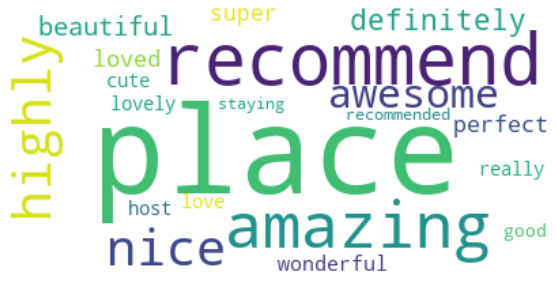

In [144]:
second_top_dict = second_top.to_dict()
wc = WordCloud(background_color="white", max_words=20).generate_from_frequencies(second_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic2')
plt.show()


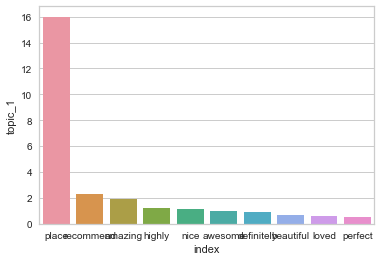

In [145]:
t2_df = t2_10.to_frame()
t2_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_1', data=t2_df);

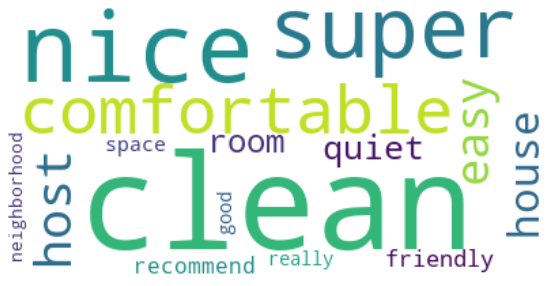

In [149]:
third_top = top_words(word_topic_matrix_df, 'topic_2', 100)
t3_10 = top_words(word_topic_matrix_df, 'topic_2', 10)


third_top_dict = third_top.to_dict()
wc = WordCloud(background_color="white", max_words=15).generate_from_frequencies(third_top_dict)
plt.figure(figsize=[10,5])
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.savefig('topic3')
plt.show()

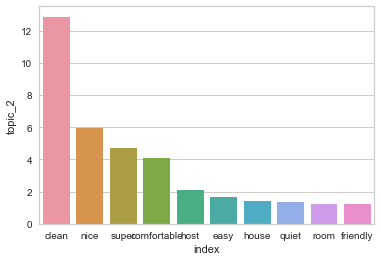

In [147]:
t3_df = t3_10.to_frame()
t3_df.reset_index(inplace=True)
sns.barplot(x='index', y='topic_2', data=t3_df);